In [1]:
from __future__ import print_function

import double_log
def print(*args, **kwargs):
    return double_log.print(*args, **kwargs)

import pickle
import pandas as pd
import numpy as np

import keras
from keras.engine.topology import Layer
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Softmax
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import plot_conf_matrix as pcm

print("=====IMPORTING|||SCRIPT STARTS|||LOGGING PURPOSE======")

/home/nyuad/anaconda2/envs/Gabor/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


=====IMPORTING|||SCRIPT STARTS|||LOGGING PURPOSE======


In [2]:
with open('../../Images/MNIST_noisy/noisy_mnist_80.pickle', 'rb') as fp:
    mnist_noise = pickle.load(fp)
print(mnist_noise.keys())

['test', 'train']


60000 train samples
10000 test samples
11949  elems are true in train
1954  elems are true in test


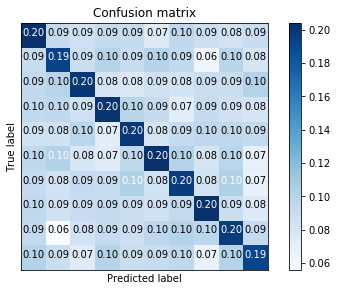

In [3]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
# the data, split between train and test sets
y_train = mnist_noise['train']
y_test = mnist_noise['test']

(x_train, y_train_clean), (x_test, y_test_clean) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print(np.sum(y_train == y_train_clean), " elems are true in train")
print(np.sum(y_test == y_test_clean), " elems are true in test")
pcm.plot_confusion_matrix(y_train_clean, y_train, normalize=True)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_test_clean = keras.utils.to_categorical(y_test_clean, num_classes)

In [26]:
## SWITCH BETWEEN NOISY AND CLEAN DATA
#y_test = y_test_clean

## CUSTOM WEIGHT LAYER FROM CONF MATRIX
class MyLayer(Layer):

    def __init__(self, output_dim, true_lab, noisy_lab, **kwargs):
        self.output_dim = output_dim
        self.conf_matrix = 
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x):
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [38]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.add(Softmax())
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#Learning the noise model
noise_model = Sequential()
noise_model.add(Dense(num_classes*num_classes, activation='linear', input_shape=(1, num_classes)))
noise_model.add(Dropout(0.1))
noise_model.add(Softmax())

noise_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

chain_model = Model(input=model.input, output = noise_model(model.output))
chain_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
chain_model.trainable = False

print("====Train start======")
print_callback = keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch,logs: double_log.logger.debug('epoch: '+ str(epoch+1)+ ' loss: '+ str(logs['loss'])+ ' accuracy: ' +str(logs['acc'])))

chain_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[print_callback])
score = chain_model.evaluate(x_test, y_test_clean, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print("====Train end======")

====Train start======


/home/nyuad/anaconda2/envs/Gabor/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("co...)`


ValueError: Error when checking target: expected sequential_19 to have shape (100,) but got array with shape (10,)

In [39]:
chain_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21_input (InputLayer) (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               1179776   
__________

In [20]:
model.layers.pop()
model.layers.pop()
model.layers.pop()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

In [21]:

model2 = Model(model.input, model.layers[-1].output)

In [36]:

score = model.evaluate(x_test, y_test_clean, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 4.930626992034912
Test accuracy: 0.0396


### clean data: 0.9874
### 20% noisy data: 0.9858
### 30% noisy data: 0.9843
### 40% noisy data: 0.9808
### 50% noisy data: 0.9785
### 70% noisy data: 0.9492
### 80% noisy data: 0.8506